# Lesson 3.07 Modeling Walkthrough

## Importing libaries
---

We'll need the following libraries for today's lesson:

1. `pandas`
2. `numpy`
3. `seaborn`
4. `matplotlib.pyplot`
5. `shap`
6. `train_test_split` and `cross_val_score` from `sklearn`'s `model_selection` module
7. `LinearRegression`, `LassoCV` and `RidgeCV` from `sklearn`'s `linear_model` module
8. `StandardScaler` from `sklearn`'s `preprocessing` module
9. `r2_score` from `sklearn`'s `metrics` module 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

## Load the Data

---

Today's [dataset](http://www-bcf.usc.edu/~gareth/ISL/data.html) (`College.csv`) is from the [ISLR website](http://www-bcf.usc.edu/~gareth/ISL/). 

Rename `Unnamed: 0` to `University`.

In [2]:
df = pd.read_csv('../datasets/College.csv')
df.rename(columns={'Unnamed: 0': 'University'}, inplace=True)
df.head()

,University,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


## Data cleaning: Initial check
---

Check the following in the cells below:
1. Do we have any null values?
2. Are any numerical columns being read in as `object`?

In [3]:
# Check for nulls
df.isnull().sum()

University     0
Private        0
Apps           0
Accept         0
Enroll         0
Top10perc      0
Top25perc      0
F.Undergrad    0
P.Undergrad    0
Outstate       0
Room.Board     0
Books          0
Personal       0
PhD            0
Terminal       0
S.F.Ratio      0
perc.alumni    0
Expend         0
Grad.Rate      0
dtype: int64

In [4]:
# Check column data types
df.dtypes

University      object
Private         object
Apps             int64
Accept           int64
Enroll           int64
Top10perc        int64
Top25perc        int64
F.Undergrad      int64
P.Undergrad      int64
Outstate         int64
Room.Board       int64
Books            int64
Personal         int64
PhD             object
Terminal         int64
S.F.Ratio      float64
perc.alumni      int64
Expend           int64
Grad.Rate        int64
dtype: object

## Data cleaning: Clean up `PhD` column
---

`PhD` is being read in as a string because some of the cells contain non-numerical values. In the cell below, replace any non-numerical values with `NaN`'s, and change the column datatype to float.

In [5]:
df.PhD = df.PhD.map(lambda phd: np.nan if phd == '?' else float(phd))

In [6]:
df.dtypes

University      object
Private         object
Apps             int64
Accept           int64
Enroll           int64
Top10perc        int64
Top25perc        int64
F.Undergrad      int64
P.Undergrad      int64
Outstate         int64
Room.Board       int64
Books            int64
Personal         int64
PhD            float64
Terminal         int64
S.F.Ratio      float64
perc.alumni      int64
Expend           int64
Grad.Rate        int64
dtype: object

In [7]:
df.isnull().sum()

University      0
Private         0
Apps            0
Accept          0
Enroll          0
Top10perc       0
Top25perc       0
F.Undergrad     0
P.Undergrad     0
Outstate        0
Room.Board      0
Books           0
Personal        0
PhD            29
Terminal        0
S.F.Ratio       0
perc.alumni     0
Expend          0
Grad.Rate       0
dtype: int64

## Data cleaning: Drop `NaN`'s
---

Since there are a small percentage of null cells, let's go ahead and drop them.

In [8]:
df.shape

(777, 19)

In [9]:
df.dropna(inplace=True)

In [10]:
df.shape

(748, 19)

## Feature engineering: Binarize `'Private'` column
---

In the cells below, convert the `Private` column into numerical values.

In [11]:
df['Private'].value_counts()

Yes    544
No     204
Name: Private, dtype: int64

In [12]:
df['Private'] = df['Private'].map({'Yes': 1, 'No': 0})

## EDA: Plot a Heatmap of the Correlation Matrix
---

Heatmaps are an effective way to visually examine the correlational structure of your predictors. 

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<AxesSubplot:>

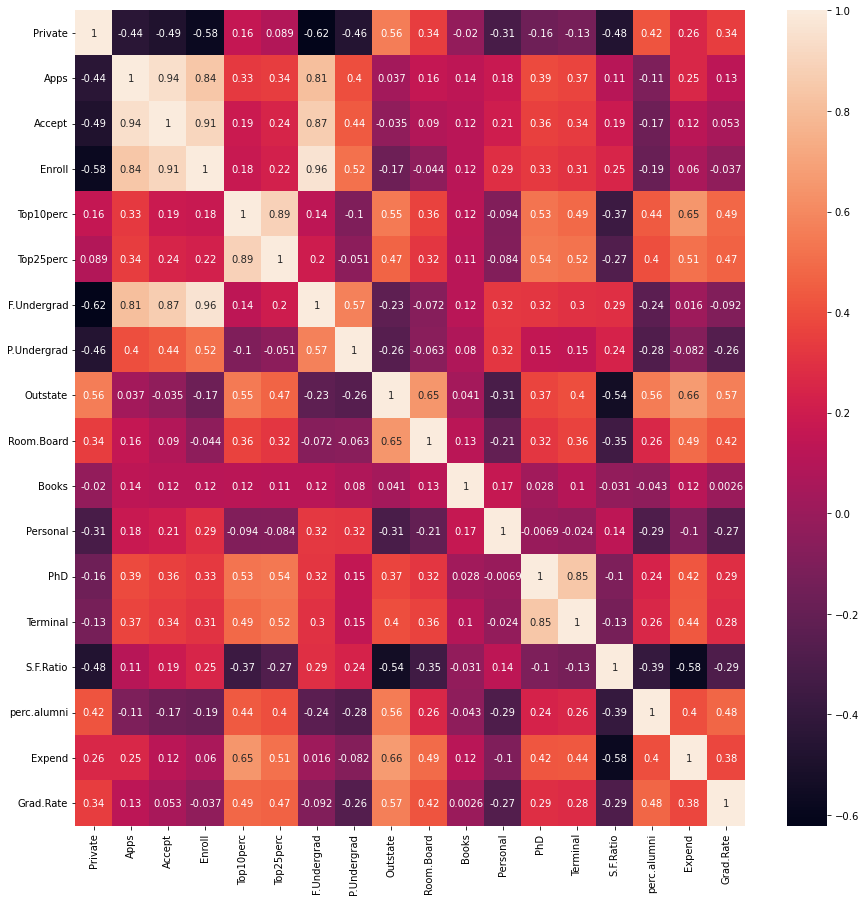

In [13]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True)

## EDA: Use seaborn's `.pairplot()` method to create scatterplots 
---

Let's create a pairplot to see how some of our stronger predictors correlate to our target (`Apps`). Instead of creating a pairplot of the entire DataFrame, we can use the `y_vars` and `x_vars` params to get a smaller subset.

In [14]:
df.corr()['Apps'].sort_values()

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


Private       -0.441434
perc.alumni   -0.105778
Outstate       0.036517
S.F.Ratio      0.109378
Grad.Rate      0.129846
Books          0.138333
Room.Board     0.162503
Personal       0.182639
Expend         0.252854
Top10perc      0.330712
Top25perc      0.344498
Terminal       0.368173
PhD            0.389312
P.Undergrad    0.400406
F.Undergrad    0.811162
Enroll         0.842801
Accept         0.943316
Apps           1.000000
Name: Apps, dtype: float64

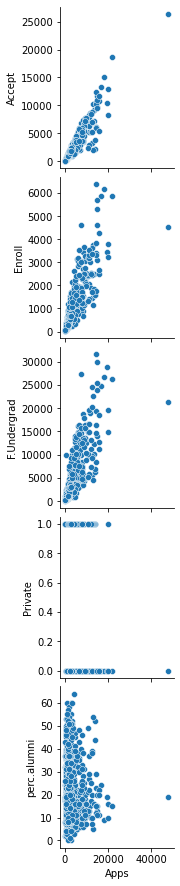

In [15]:
sns.pairplot(df, y_vars=['Accept', 'Enroll', 'F.Undergrad', 'Private', 'perc.alumni'], x_vars=['Apps'])

## EDA: Create histograms of all numerical columns
---

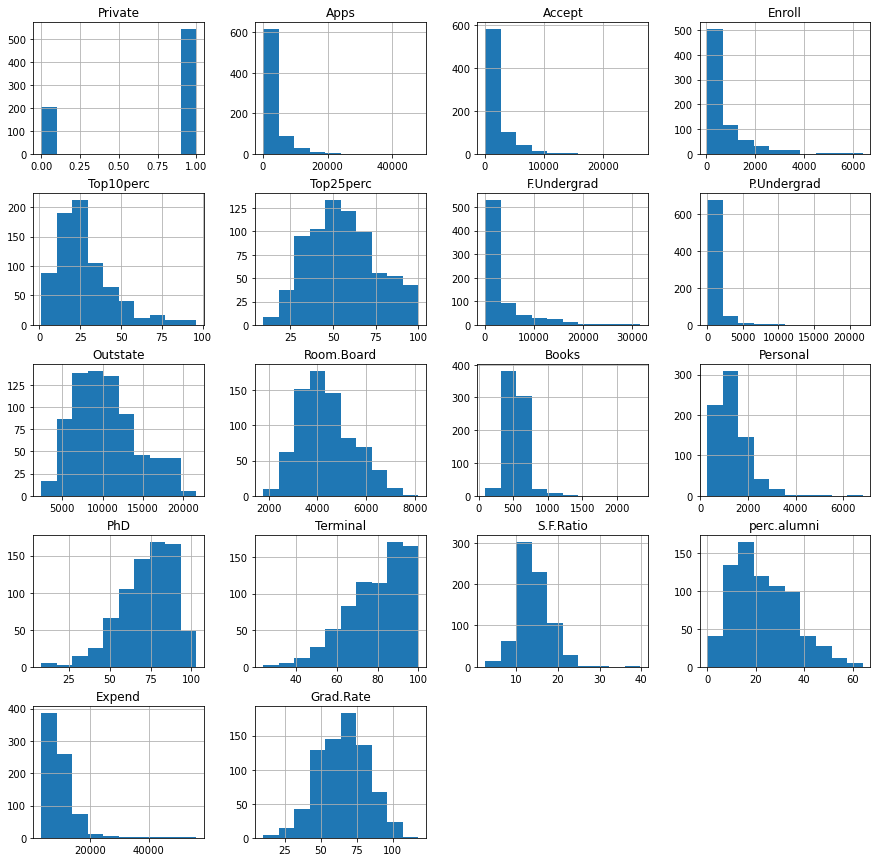

In [16]:
df.hist(figsize=(15, 15));

## EDA: Boxplots
---

In the cells below, create two boxplots:
1. One for our target (`Apps`)
2. And one for our strongest predictor (`Accept`)

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='Apps'>

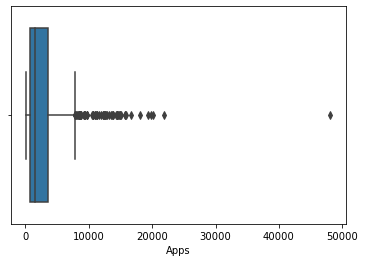

In [17]:
sns.boxplot(df['Apps'])

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='Accept'>

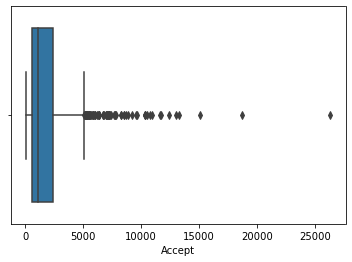

In [18]:
sns.boxplot(df['Accept'])

## Model Prep: Create our features matrix (`X`) and target vector (`y`)
---

Every **numerical** column (that is not our target) will be used as a feature.

The `Apps` column is our label: the number of applications received by that university.

In the cell below, create your `X` and `y` variables.

In [19]:
# for each column, load in only if it is numeric and not Apps
features = [col for col in df._get_numeric_data().columns if col != 'Apps']
X = df[features]
y = df['Apps']

## Model Prep: Train/test split
---

We always want to have a holdout set to test our model. Use the `train_test_split` function to split our `X` and `y` variables into a training set and a holdout set.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Model Prep: Scaling
---

Since we're using `Lasso` and `Ridge`, we'll want to scale our features. In the cell below, fit a `StandardScaler` to `X_train` and use it to transform both `X_train` and `X_test`.

In [21]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

## Model Prep: Instantiate our models
---

We'll be evaluating `LinearRegression`, `LassoCV` and `RidgeCV`, so we'll need to create instances of all three models.

**Important**
- We are not fitting the models yet in this section. 
- We are only creating copies of the required model classes
- The models will be fitted in the next section using cross_val_score

In [22]:
lr = LinearRegression()

In [23]:
# To test out 200 different alpha values on default 5-folds of data set and adopt the best performing alpha
# More info at https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html
lasso = LassoCV(n_alphas=200)

In [24]:
# To test out 100 different evenly spaced alpha values between 0.1 and 10 on default 5-folds of data set and adopt the best performing alpha
# More info at https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

## Cross validation
---
- `cross_val_score` may be used to fit and evaluate all three models.
- `cross_val_score` fits the model to each fold in the train data provided when it is running CV so we won't need to fit the model separately prior to invoking cross_val_score.

In [25]:
# Generate the cross_val score for LR fitted to train data
lr_scores = cross_val_score(lr, X_train_sc, y_train, cv=3)
lr_scores.mean()

0.911349266788128

In [26]:
# Generate the cross_val score for Lasso CV (i.e. with optimal alpha value) fitted to train data
lasso_scores = cross_val_score(lasso, X_train_sc, y_train, cv=3)
lasso_scores.mean()

0.9141628167115297

In [27]:
# Generate the cross_val score for Ridge CV (i.e. with optimal alpha value) fitted to train data
ridge_scores = cross_val_score(ridge, X_train_sc, y_train, cv=3)
ridge_scores.mean()

0.9109281882193909

## Model Fitting and Evaluation
---

- `LassoCV` seems to be doing the best on train data, so let's move forward with that model. 
- Fit the model to the training data, and evaluate the training and test scores below.

In [28]:
# Since the section above only computes the cross val scores, we need to proceed to fit the model so that we can make predictions
lasso.fit(X_train_sc, y_train)

LassoCV(n_alphas=200)

In [29]:
lasso.score(X_train_sc, y_train)

0.9239260185648017

In [30]:
lasso.score(X_test_sc, y_test)

0.9124706934793004

In [31]:
lasso_scores.mean()

0.9141628167115297

In [32]:
pred = lasso.predict(X_test_sc)

<AxesSubplot:>

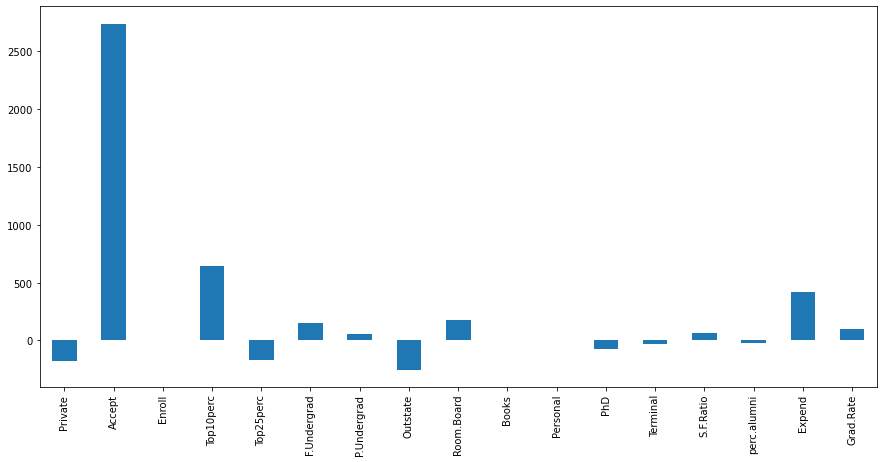

In [33]:
pd.Series(lasso.coef_, index=features).plot.bar(figsize=(15, 7))

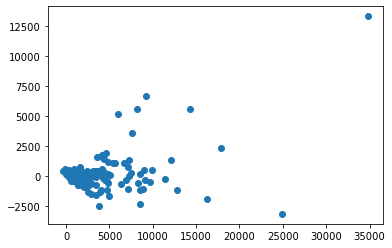

In [34]:
# Plot predictions (x-axis) against residuals (y-axis)
# Closer the scatter is to a horizontal line across zero, the better the model
residuals = y_test - pred
plt.scatter(pred, residuals)